# Conteo de Células Rojas
**Ricardo Antonio Gutiérrez Esparza** \
**Juan Marquina Cancino**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Operadores morfológicos

In [2]:
def Dilation(kernel, img):
    '''Para evitar que se salgan del kernel, agregamos ceros a los bordes'''
    N = img.shape[0]
    M = img.shape[1]

    kN = kernel.shape[0]
    kM = kernel.shape[1]

    kernel = np.array(kernel, dtype=int)
    base = np.count_nonzero(kernel)

    ans = np.zeros(img.shape)*255
    extended = img.copy() 
    extended = np.append(np.append(np.zeros((kN // 2, M)), extended, axis=0), np.zeros((kN // 2, M)), axis=0)
    extended = np.append(np.append(np.zeros((extended.shape[0], kM // 2)), extended, axis=1), np.zeros((extended.shape[0], kM // 2)), axis=1)
    for i in range(0,N):
        for j in range(0, M):
            #print(i, j, i-kN+1, j-kM+1, j+1, kernel.shape)
            imgKern = np.array(extended[i:i + kN, j:j + kM], dtype=int)
            ##imgKern = img[0:5,0:5]
            
            #print(imgKern)
            imgCheck = imgKern + kernel
            imgCheck -= np.ones(imgKern.shape, dtype=int)*255*2
            cc = np.count_nonzero(imgCheck==0)
            if(cc > 0):
                ans[i,j] = 255
            else:
                ans[i,j] = 0
    return ans

In [3]:
def Erosion(kernel, img):
    r''' Los que se salen del kernel, son 0'''
    N = img.shape[0]
    M = img.shape[1]

    kN = kernel.shape[0]
    kM = kernel.shape[1]

    kernel = np.array(kernel, dtype=int)
    base = np.count_nonzero(kernel)

    ans = np.zeros(img.shape)
    for i in range(0+kN-1,N):
        for j in range(0+kM-1, M):
            imgKern = np.array(img[i-kN+1:i+1, j-kM+1:j+1], dtype=int)
            imgCheck = imgKern + kernel

            imgCheck -= np.ones(imgKern.shape, dtype=int)*255*2
            cc = np.count_nonzero(imgCheck==0)
            
            if(base == cc):
                ans[i-int(kN/2)][j-int(kM/2)] = 255
                
    return ans

In [4]:
def Open(kernel, img):
    return Dilation(kernel, Erosion(kernel, img))

## Preprocesar imagen

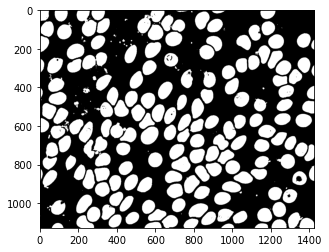

In [5]:
# Obtener imagen binaria
img = cv2.imread('sample.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)[1]
img = 255 - img
plt.imshow(img, cmap='gray')

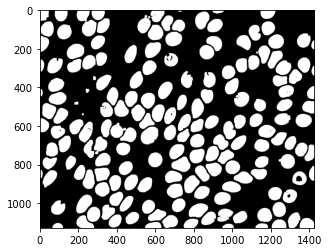

In [6]:
# Filtar ruido con un open, usando kernel cuadrado 
kernel = np.ones((9,9))*255
img = Open(kernel, img)
plt.imshow(img, cmap='gray')

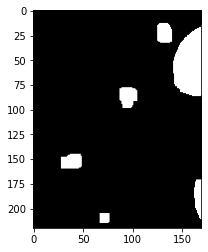

In [7]:
# Sección con ruido #1
plt.imshow(img[330:550,150:320], cmap='gray')

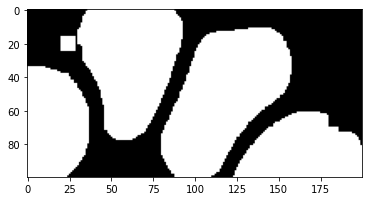

In [8]:
# Sección con ruido #2
plt.imshow(img[200:300,1100:1300], cmap='gray')

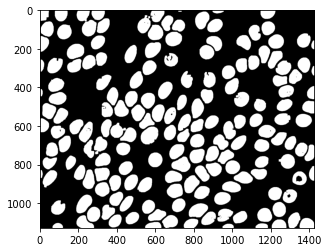

In [9]:
# Limpiar con un kernel más grande
kernel = np.ones((15,15))*255
img[330:550,150:320] = Open(kernel, img[330:550,150:320])
img[200:300,1100:1300] = Open(kernel, img[200:300,1100:1300])
plt.imshow(img, cmap='gray')

## Contar

In [10]:
def count_cells(img):
    marked = np.zeros(img.shape, dtype=bool)
    vicinity = [(0, -1), (0, 1), (-1, 0), (1, 0),
                (1, -1), (1, 1), (-1, 1), (-1, -1)]
    colored_img = img.copy()

    def in_bounds(img, x, y):
        return x < img.shape[0] and x >= 0 and y < img.shape[1] and y >= 0
    
    def bfs(img, s_x, s_y):
        rand_color = np.random.randint(50, 230)
        queue = [(s_x, s_y)]
        marked[s_x, s_y] = True
        colored_img[s_x, s_y] = rand_color
        cluster = [(s_x, s_y)]
        while len(queue):
            x, y = queue[0]
            for delta in vicinity:
                cand_x, cand_y = x + delta[0], y + delta[1]
                if in_bounds(img, cand_x, cand_y) and not marked[cand_x, cand_y] and img[cand_x, cand_y] == 255:
                    marked[cand_x, cand_y] = True
                    colored_img[cand_x, cand_y] = rand_color
                    queue.append((cand_x, cand_y))
                    cluster.append((cand_x, cand_y))
                    
            queue = queue[1:]
        
        return np.mean(cluster, axis=0)
    
    centroids = []
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if img[x, y] == 255 and not marked[x, y]:
                centroids.append(bfs(img, x, y))

    return centroids, colored_img

In [11]:
centroids, colored_img = count_cells(img)

Total de células:  173


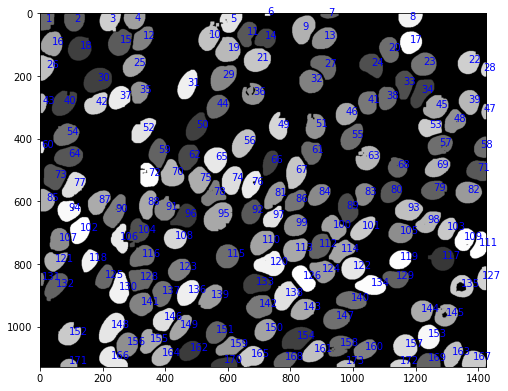

In [12]:
print('Total de células: ', len(centroids))
plt.figure(figsize=(8, 10))
plt.imshow(colored_img, cmap='gray')
for idx, v in enumerate(centroids):
    plt.text(v[1], v[0], str(idx + 1), c='blue')